# Historical data analysis
This Notebook analyses the compressed historical dataframes and wants to answer two questions with plots.
1. After how many months does a prepayment occurs, in case if it occurs. (This is not dependent on the starting date).
2. Can we find a relation between interest rates moves and prepayment.


In [1]:
import pyarrow
import pandas as pd
import polars as pl
import numpy as np
import sweetviz as sv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
counter1 = Counter()

In [3]:
%%time

# Iterate over each year and quarter
for year in range(2006, 2023):  # 2024 because the range end is exclusive
    for quarter in range(1, 5):  # From Q1 to Q4
        print(year,quarter)
        input_path = f'data/hist_data_time_{year}Q{quarter}.parquet'
        df = pd.read_parquet(input_path)
        count_values_when_target_is_one = df.loc[df['TARGET'] == 1, 'COUNT']
        counter1.update(count_values_when_target_is_one)

2006 1
2006 2
2006 3
2006 4
2007 1
2007 2
2007 3
2007 4
2008 1
2008 2
2008 3
2008 4
2009 1
2009 2
2009 3
2009 4
2010 1
2010 2
2010 3
2010 4
2011 1
2011 2
2011 3
2011 4
2012 1
2012 2
2012 3
2012 4
2013 1
2013 2
2013 3
2013 4
2014 1
2014 2
2014 3
2014 4
2015 1
2015 2
2015 3
2015 4
2016 1
2016 2
2016 3
2016 4
2017 1
2017 2
2017 3
2017 4
2018 1
2018 2
2018 3
2018 4
2019 1
2019 2
2019 3
2019 4
2020 1
2020 2
2020 3
2020 4
2021 1
2021 2
2021 3
2021 4
2022 1
2022 2
2022 3
2022 4
CPU times: user 4.27 s, sys: 1.14 s, total: 5.41 s
Wall time: 5.36 s


In [4]:
counter1_df = pd.DataFrame.from_records(list(counter1.items()), columns=['Months till Prepayment', 'Count'])
sorted_df = counter1_df.sort_values(by='Months till Prepayment', ascending=True)
months = sorted_df['Months till Prepayment']
count = sorted_df['Count']

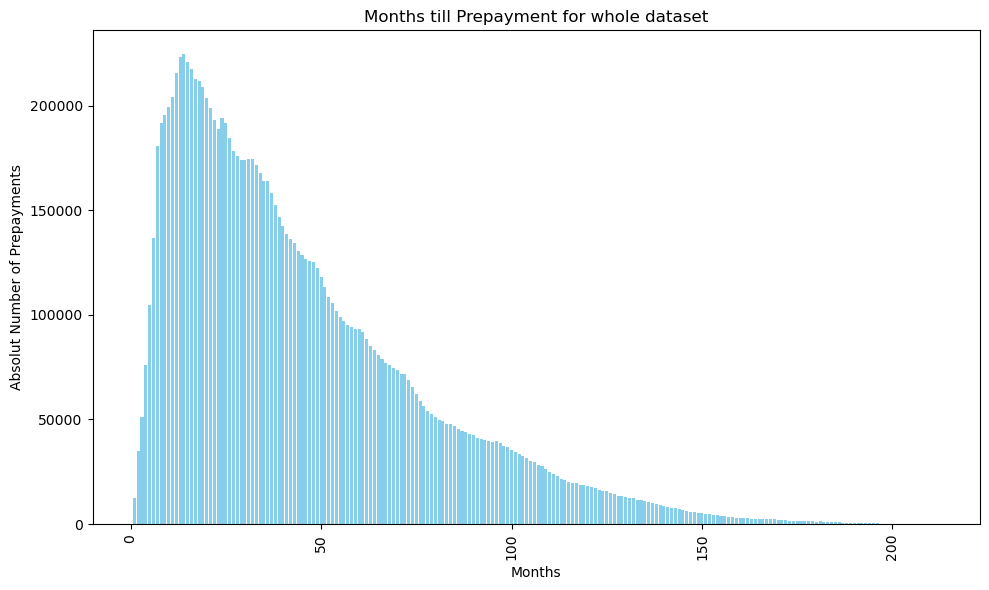

In [5]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(months, count, color='skyblue')
plt.xlabel('Months')
plt.ylabel('Absolut Number of Prepayments')
plt.title('Months till Prepayment for whole dataset')
plt.xticks(rotation=90)  # Rotating x labels to avoid overlap
plt.tight_layout()  # Adjust layout for better fit
#plt.show()
plt.savefig('PrepaymentsbyMonth.png')

## art 2: Finding a reasonable Cutoff - Period to test our model

In [6]:
sorted_df.describe()

,Months till Prepayment,Count
count,212.000000,212.000000
mean,106.500000,57915.679245
std,61.343296,67694.676816
min,1.000000,15.000000
25%,53.750000,3114.250000
50%,106.500000,28000.500000
75%,159.250000,94387.250000
max,212.000000,224747.000000


In [7]:
# Calculate the cumulative sum of counts
sorted_df['CumulativeCount'] = sorted_df['Count'].cumsum()

# Calculate the total sum of counts
total_count = sorted_df['Count'].sum()

# Calculate the 85% threshold of the total count
threshold = total_count * 0.85

# Find the smallest 'Item' value where the cumulative count equals or exceeds the 85% threshold
threshold_item = sorted_df[sorted_df['CumulativeCount'] >= threshold].iloc[0]['Months till Prepayment']
threshold_item

79

Hence we propose a testing period of 6.5 years to get a reasonable amount of data. We rerun our code with data up to till 2016 to look at the distribution of it. 

In [8]:
counter2 = Counter()

In [9]:
%%time

# Iterate over each year and quarter
for year in range(2006, 2017):
    for quarter in range(1, 5):  # From Q1 to Q4
        print(year,quarter)
        input_path = f'data/hist_data_time_{year}Q{quarter}.parquet'
        df = pd.read_parquet(input_path)
        count_values_when_target_is_one = df.loc[df['TARGET'] == 1, 'COUNT']
        counter2.update(count_values_when_target_is_one)

2006 1
2006 2
2006 3
2006 4
2007 1
2007 2
2007 3
2007 4
2008 1
2008 2
2008 3
2008 4
2009 1
2009 2
2009 3
2009 4
2010 1
2010 2
2010 3
2010 4
2011 1
2011 2
2011 3
2011 4
2012 1
2012 2
2012 3
2012 4
2013 1
2013 2
2013 3
2013 4
2014 1
2014 2
2014 3
2014 4
2015 1
2015 2
2015 3
2015 4
2016 1
2016 2
2016 3
2016 4
CPU times: user 2.36 s, sys: 505 ms, total: 2.87 s
Wall time: 2.7 s


In [10]:
counter2_df = pd.DataFrame.from_records(list(counter2.items()), columns=['Months till Prepayment', 'Count'])
sorted_df = counter2_df.sort_values(by='Months till Prepayment', ascending=True)
months = sorted_df['Months till Prepayment']
count = sorted_df['Count']

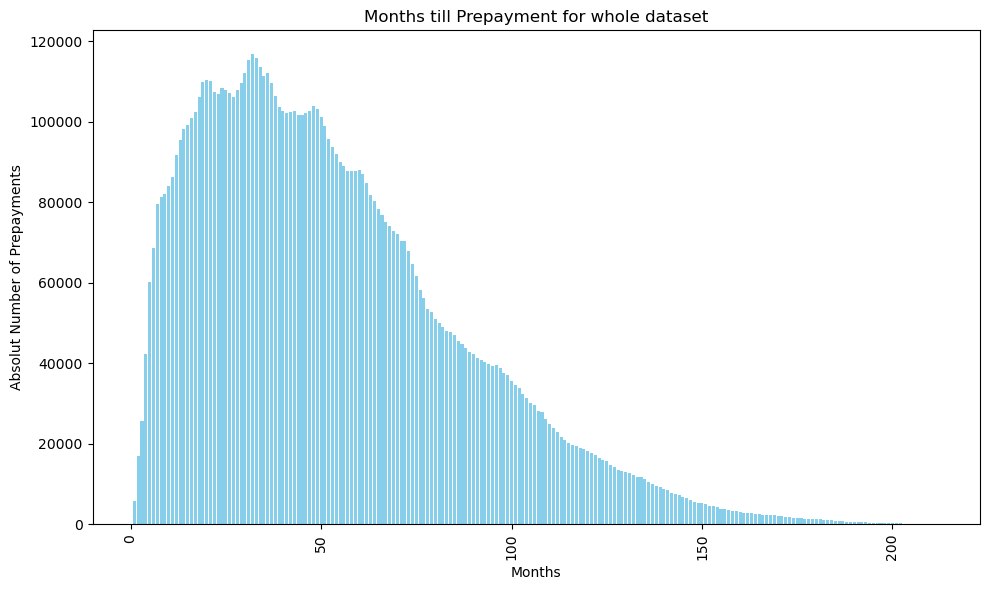

In [11]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(months, count, color='skyblue')
plt.xlabel('Months')
plt.ylabel('Absolut Number of Prepayments')
plt.title('Months till Prepayment for whole dataset')
plt.xticks(rotation=90)  # Rotating x labels to avoid overlap
plt.tight_layout()  # Adjust layout for better fit
#plt.show()
plt.savefig('PrepaymentsbyMonthCutOff.png')

In [12]:
# Calculate the cumulative sum of counts
sorted_df['CumulativeCount'] = sorted_df['Count'].cumsum()

# Calculate the total sum of counts
total_count = sorted_df['Count'].sum()

# Calculate the 85% threshold of the total count
threshold = total_count * 0.80

# Find the smallest 'Item' value where the cumulative count equals or exceeds the 85% threshold
threshold_item = sorted_df[sorted_df['CumulativeCount'] >= threshold].iloc[0]['Months till Prepayment']
threshold_item

81

Most of the prepayments arise in the proposed horizon. Hence we choose 2016 as our cutoff period and train our model on the data till then. We will validate on our model for the data in 2017 and rolling.

# Part 2: Interest rate sensitivity of payment

In [13]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [14]:
df

,LOAN_SEQUENCE_NUMBER,MONTHLY_REPORTING_PERIOD,CURRENT_ACTUAL_UPB,ZERO_BALANCE_CODE,CURRENT_INTEREST_RATE,CURRENT_MONTH_REPURCHASE_FLAG,TARGET,COUNT
0,F16Q40000002,201612,517000.0,NaN,3.625,517000.0,0.0,82
1,F16Q40000003,201611,225000.0,NaN,3.625,225000.0,0.0,83
2,F16Q40000004,201702,60000.0,NaN,4.375,60000.0,1.0,10
3,F16Q40000005,201611,152000.0,NaN,3.375,152000.0,1.0,24
4,F16Q40000007,201611,99000.0,NaN,5.250,99000.0,1.0,32
...,...,...,...,...,...,...,...,...
282449,F16Q40471353,201811,282000.0,NaN,5.000,282000.0,1.0,25
282450,F16Q40471357,201811,400000.0,NaN,4.875,400000.0,1.0,22
282451,F16Q40471393,201903,149000.0,NaN,4.500,149000.0,1.0,17
282452,F16Q40471897,201903,359000.0,NaN,4.750,359000.0,1.0,9


In [15]:
# Convert 'MONTHLY_REPORTING_PERIOD' to datetime, assuming the format is YYYYMM
df['MONTHLY_REPORTING_PERIOD_datetime'] = pd.to_datetime(df['MONTHLY_REPORTING_PERIOD'], format='%Y%m')


In [16]:
df

,LOAN_SEQUENCE_NUMBER,MONTHLY_REPORTING_PERIOD,CURRENT_ACTUAL_UPB,ZERO_BALANCE_CODE,CURRENT_INTEREST_RATE,CURRENT_MONTH_REPURCHASE_FLAG,TARGET,COUNT,MONTHLY_REPORTING_PERIOD_datetime
0,F16Q40000002,201612,517000.0,NaN,3.625,517000.0,0.0,82,2016-12-01
1,F16Q40000003,201611,225000.0,NaN,3.625,225000.0,0.0,83,2016-11-01
2,F16Q40000004,201702,60000.0,NaN,4.375,60000.0,1.0,10,2017-02-01
3,F16Q40000005,201611,152000.0,NaN,3.375,152000.0,1.0,24,2016-11-01
4,F16Q40000007,201611,99000.0,NaN,5.250,99000.0,1.0,32,2016-11-01
...,...,...,...,...,...,...,...,...,...
282449,F16Q40471353,201811,282000.0,NaN,5.000,282000.0,1.0,25,2018-11-01
282450,F16Q40471357,201811,400000.0,NaN,4.875,400000.0,1.0,22,2018-11-01
282451,F16Q40471393,201903,149000.0,NaN,4.500,149000.0,1.0,17,2019-03-01
282452,F16Q40471897,201903,359000.0,NaN,4.750,359000.0,1.0,9,2019-03-01


In [17]:
def add_months(row):
    return row['MONTHLY_REPORTING_PERIOD_datetime'] + relativedelta(months=row['COUNT'])


In [18]:
# Apply the function and create the new column
df['FINAL_PERIOD'] = df.apply(add_months, axis=1)

In [19]:
df

,LOAN_SEQUENCE_NUMBER,MONTHLY_REPORTING_PERIOD,CURRENT_ACTUAL_UPB,ZERO_BALANCE_CODE,CURRENT_INTEREST_RATE,CURRENT_MONTH_REPURCHASE_FLAG,TARGET,COUNT,MONTHLY_REPORTING_PERIOD_datetime,FINAL_PERIOD
0,F16Q40000002,201612,517000.0,NaN,3.625,517000.0,0.0,82,2016-12-01,2023-10-01
1,F16Q40000003,201611,225000.0,NaN,3.625,225000.0,0.0,83,2016-11-01,2023-10-01
2,F16Q40000004,201702,60000.0,NaN,4.375,60000.0,1.0,10,2017-02-01,2017-12-01
3,F16Q40000005,201611,152000.0,NaN,3.375,152000.0,1.0,24,2016-11-01,2018-11-01
4,F16Q40000007,201611,99000.0,NaN,5.250,99000.0,1.0,32,2016-11-01,2019-07-01
...,...,...,...,...,...,...,...,...,...,...
282449,F16Q40471353,201811,282000.0,NaN,5.000,282000.0,1.0,25,2018-11-01,2020-12-01
282450,F16Q40471357,201811,400000.0,NaN,4.875,400000.0,1.0,22,2018-11-01,2020-09-01
282451,F16Q40471393,201903,149000.0,NaN,4.500,149000.0,1.0,17,2019-03-01,2020-08-01
282452,F16Q40471897,201903,359000.0,NaN,4.750,359000.0,1.0,9,2019-03-01,2019-12-01


Count the final periods in the dataset and visualise them in the same way as before.

In [20]:
counter3 = Counter()

In [21]:
%%time

# Iterate over each year and quarter
for year in range(2006, 2023):
    for quarter in range(1, 5):  # From Q1 to Q4
        print(year,quarter)
        input_path = f'data/hist_data_time_{year}Q{quarter}.parquet'
        df = pd.read_parquet(input_path)
        # Convert 'MONTHLY_REPORTING_PERIOD' to datetime, assuming the format is YYYYMM
        df['MONTHLY_REPORTING_PERIOD_datetime'] = pd.to_datetime(df['MONTHLY_REPORTING_PERIOD'], format='%Y%m')
        # Apply the function and create the new column
        df['FINAL_PERIOD'] = df.apply(add_months, axis=1)
        target_ones = df[df['TARGET'] == 1]
        counter3.update(target_ones['FINAL_PERIOD'])

2006 1
2006 2
2006 3
2006 4
2007 1
2007 2
2007 3
2007 4
2008 1
2008 2
2008 3
2008 4
2009 1
2009 2
2009 3
2009 4
2010 1
2010 2
2010 3
2010 4
2011 1
2011 2
2011 3
2011 4
2012 1
2012 2
2012 3
2012 4
2013 1
2013 2
2013 3
2013 4
2014 1
2014 2
2014 3
2014 4
2015 1
2015 2
2015 3
2015 4
2016 1
2016 2
2016 3
2016 4
2017 1
2017 2
2017 3
2017 4
2018 1
2018 2
2018 3
2018 4
2019 1
2019 2
2019 3
2019 4
2020 1
2020 2
2020 3
2020 4
2021 1
2021 2
2021 3
2021 4
2022 1
2022 2
2022 3
2022 4
CPU times: user 4min 35s, sys: 15.1 s, total: 4min 50s
Wall time: 5min 7s


TODO: Mistake, include another column that indicates what happend. Default or just paid through, this can vary by a month

In [22]:
# Convert the Counter to a DataFrame for easy sorting and manipulation
df_counter = pd.DataFrame(counter3.items(), columns=['Timestamp', 'Count'])

# Sort the DataFrame by Timestamp
df_counter_sorted = df_counter.sort_values(by='Timestamp')

In [23]:
df_counter_sorted

,Timestamp,Count
182,2006-02-01,1
51,2006-03-01,52
55,2006-04-01,217
130,2006-05-01,349
117,2006-06-01,637
...,...,...
245,2040-05-01,3
408,2040-06-01,1
363,2040-07-01,1
400,2040-08-01,1


In [24]:
interest_rates = pd.read_csv('Interest_rate_data_monthly.csv')
interest_rates.columns = ["Timestamp", "RATE"]
interest_rates['Timestamp'] = pd.to_datetime(interest_rates['Timestamp'])

In [25]:
interest_rates

,Timestamp,RATE
0,2006-02-01,4.49
1,2006-03-01,4.59
2,2006-04-01,4.79
3,2006-05-01,4.94
4,2006-06-01,4.99
...,...,...
213,2023-11-01,5.33
214,2023-12-01,5.33
215,2024-01-01,5.33
216,2024-02-01,5.33


In [26]:
df_counter_sorted = pd.merge(df_counter_sorted, interest_rates, how='inner', on='Timestamp')

In [27]:
df_counter_sorted

,Timestamp,Count,RATE
0,2006-02-01,1,4.49
1,2006-03-01,52,4.59
2,2006-04-01,217,4.79
3,2006-05-01,349,4.94
4,2006-06-01,637,4.99
...,...,...,...
213,2023-11-01,44,5.33
214,2023-12-01,39,5.33
215,2024-01-01,57,5.33
216,2024-02-01,39,5.33


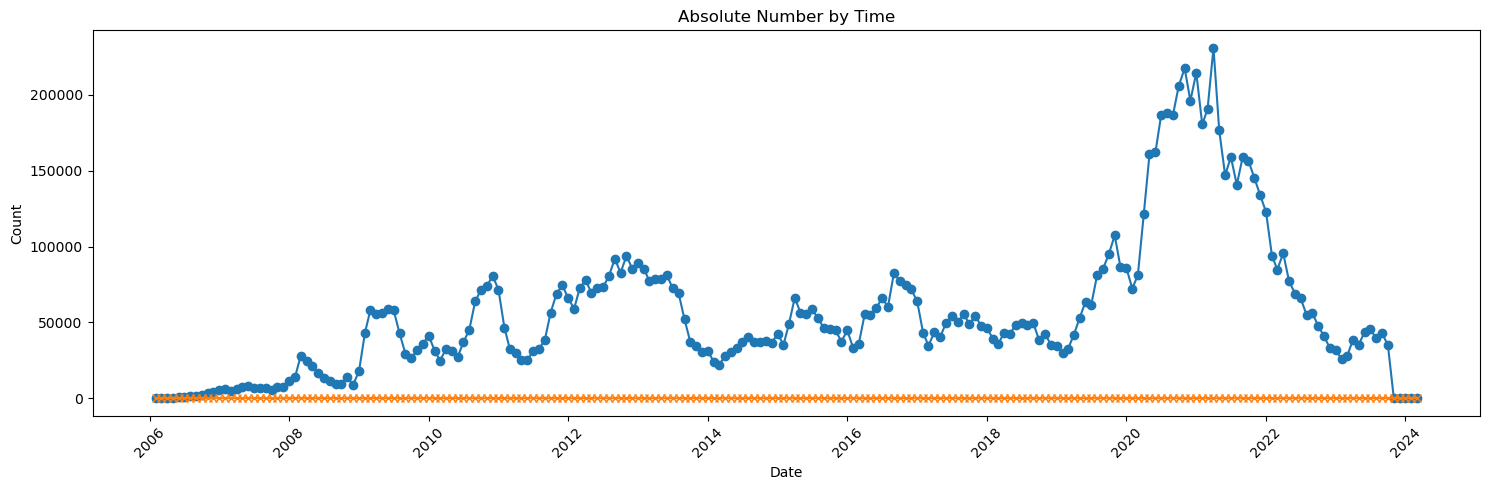

In [28]:
# Plotting
plt.figure(figsize=(15, 5))
plt.plot(df_counter_sorted['Timestamp'], df_counter_sorted['Count'], marker='o')
plt.plot(df_counter_sorted['Timestamp'], df_counter_sorted['RATE'], marker='x')

plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Absolute Number by Time')
plt.tight_layout()  # Adjust the layout
plt.show()

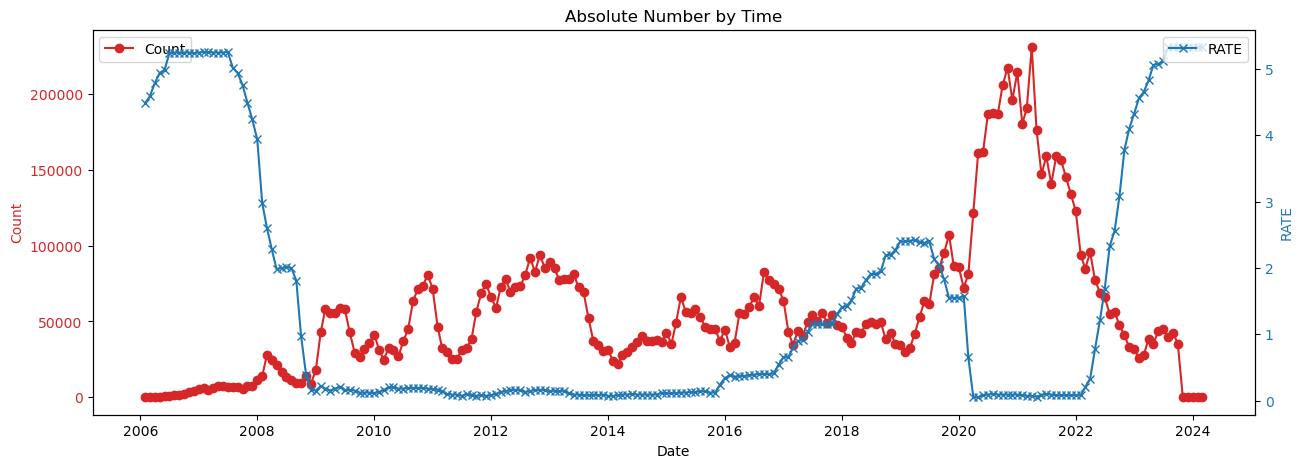

In [32]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot the first series of data
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Count', color=color)
ax1.plot(df_counter_sorted['Timestamp'], df_counter_sorted['Count'], color=color, marker='o', label='Count')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')

# Instantiate a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  

# Plot the second series of data on the second y-axis
color = 'tab:blue'
ax2.set_ylabel('RATE', color=color)  # Assume 'NewCount' is the name of the second column
ax2.plot(df_counter_sorted['Timestamp'], df_counter_sorted['RATE'], color=color, marker='x', label='RATE')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Title of the plot
plt.title('Absolute Number by Time')

# Use this command if you are not in an interactive environment to ensure layout is tight
# plt.tight_layout() 

# Show the plot
#plt.show()
plt.savefig('Prepayments_against_rate_and_time.png')

In [30]:
df = pd.read_csv('/Users/juliusgruber/Downloads/historical_data_2006/historical_data_time_2006Q1.txt')

In [31]:
df

,F06Q10000001|200603|130000.00|0|000|360|||||6.500|0.00||||||||||||||||||||130000.00
0,F06Q10000001|200604|130000.00|0|001|359|||||6....
1,F06Q10000001|200605|130000.00|0|002|358|||||6....
2,F06Q10000001|200606|130000.00|0|003|357|||||6....
3,F06Q10000001|200607|129000.00|0|004|356|||||6....
4,F06Q10000001|200608|129000.00|0|005|355|||||6....
...,...
20379138,F06Q10374577|202004|44394.76|1|053|191|||||4.0...
20379139,F06Q10374577|202005|44394.76|2|054|190|||||4.0...
20379140,F06Q10374577|202006|44394.76|3|055|189|||||4.0...
20379141,F06Q10374577|202007|44394.76|4|056|188|||||4.0...
